# Bootcamp 2020

In the last part of today I will

* introduce you to Python
* introduce you to some basic ideas about analyzing aggregates of neurons
* give some tips on cultivating your beautiful life in data

We don't have time today to give a good programming lesson, so forgive me for lack of detail on specifics of Python


First things first, in Python we explicitly "import" other code that we want to use from "packages"

In [1]:
import os
from glob import glob # wildcard file selection
from pprint import pprint # pretty printing

# load the dreaded matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

import pandas as pd      # data structures
import numpy as np       # basic numerical operations
import altair as alt     # plotting library
from scipy.io import wavfile # loading sound files
from scipy import signal # for making spectograms
from ipywidgets import interact, fixed # buttons and stuff
# with respect to https://github.com/Chekos/blog-posts/tree/master/altair%20%2B%20ipywidgets


# tell plotting library not to try and hold everything in memory
alt.data_transformers.enable('json')
# and let it render good
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

# 1 - Load Data!

I've already taken the data output from the recording and cleaned it up into "long" format -- more on that later -- using the `clean_out_dir.m` MATLAB code found in the repository

Now find and load it!

In [2]:
# start with tuning curves -- 
# build a string with a wildcard * to search for files we want
tc_search = os.path.join(os.getcwd(),'data','tones', "*.csv")

# use glob to find the files!
tc_fns = glob(tc_search)

#what did we get?
print(f"""\nSearch string: {tc_search}
          \nGlobbed Filenames: {tc_fns}""")


Search string: /Users/jonny/git/bootcamp_2020/data/tones/*.csv
          
Globbed Filenames: ['/Users/jonny/git/bootcamp_2020/data/tones/2020-09-03_17-41-32_tones.csv']


Now we'll load the file and see what inside

In [3]:
if len(tc_fns) == 1:
    # make a pandas dataframe out of our .csv file
    df = pd.read_csv(tc_fns[0])
    
# print the first n rows (default 5, try giving another number as an argument)
#df.head()
df.head(10)

,amps,cell,dur,expt,freqs,rep,spikes
0,40,1,25,tuning_curve,4000.00,1,1.566667
1,40,1,25,tuning_curve,5656.85,1,21.633333
2,40,1,25,tuning_curve,11313.70,1,26.866667
3,40,1,25,tuning_curve,11313.70,1,36.366667
4,40,1,25,tuning_curve,22627.40,1,16.666667
5,55,1,25,tuning_curve,1000.00,1,1.433333
6,55,1,25,tuning_curve,1414.21,1,21.333333
7,55,1,25,tuning_curve,1414.21,1,29.100000
8,55,1,25,tuning_curve,22627.40,1,22.300000
9,70,1,25,tuning_curve,-1.00,1,9.766667


Our data is in a format where every **row** is a single spike and every **column** is a variable that describes the spike. In this case we have

* **expt** - some short description of the type of experiment that was run
* **cell** - the cell that the spike came from
* **rep** - the repetition of the tone that was presented
* **freqs** - the frequency of the presented tone
* **amps** - the amplitude of the presented tone in dBSPL
* **dur** - the duration of the presented tone
* **spikes** - the time of the spike in ms



Since our data is in a computable format, we don't need special custom code to do simple analysis and description of it. Data has a long lifetime -- it goes through many forms, is combined with data of different types, etc -- so being purposive when deciding the format we want to store and operate on our data is extremely important to staying sane in analysis. Again more on this later

A very simple summary we can do is count the number of unique cells in our data:

In [4]:
# here we are using python f-string formatting. by putting f before the string,
# we can interpolate our variables inside of {}s

unique_cells = df['cell'].unique()
n_unique_cells = len(unique_cells)

print(f"There are {n_unique_cells} unique cells: {unique_cells}")


There are 2 unique cells: [1 7]


We can do the same thing for frequencies and amplitudes

In [5]:
uq_freqs = df['freqs'].unique()
uq_amps  = df['amps'].unique()

print('Frequencies:\n')
pprint(uq_freqs)
print('\n\nAmplitudes:\n')
pprint(uq_amps)

Frequencies:

array([ 4.00000e+03,  5.65685e+03,  1.13137e+04,  2.26274e+04,
        1.00000e+03,  1.41421e+03, -1.00000e+00,  2.82843e+03,
        1.60000e+04,  6.40000e+04,  2.00000e+03,  8.00000e+03,
        3.20000e+04,  4.52548e+04])


Amplitudes:

array([40, 55, 70])


## 2 - Spike Raster

We make a classic raster first.

I am trying out a new plotting library, [Altair](https://altair-viz.github.io), so refer to its documentation :)

First we're going to make a **function** to make the plot -- making a function lets us encapsulate all the logic of an operation we want to do (like plot a spike raster) so we don't have to write it all every time. You don't need to understand the code that goes inside of the  function for now, as it is mostly idiosyncratic to the altair library

In [6]:
def spike_raster(cell: int, data: pd.DataFrame) -> alt.Chart:
    """
    Plot a spike raster plot for a single cell
    
    Args:
        cell (int): The ID of the cell to plot
        data: (pandas.DataFrame): DataFrame object containing data
        
    Returns:
        altair.Chart: The created chart
    """
    
    # we first declare a Chart object, subsetting our data to a single cell
    # we then mark_circles with the encoding (map from data to graphics)
        
    chart = alt.Chart(data[data['cell'] == cell]).mark_circle().encode(
        x = alt.X('spikes'),      # X axis will be spike time
        y = alt.Y('rep' ),        # Y is the stimulus repetition
        size = alt.value(5),      # make the dots small
        opacity=alt.value(1.),    # opaque
        color=alt.condition(      # and...
            # if the spike happened during the stimulus presentation
            (alt.datum.spikes >= 0) & (alt.datum.spikes<=alt.datum.dur), 
            alt.value('red'),     # colored red
            alt.value('black')    # otherwise black
        )
    ).properties(
        width = 200,
        height = 30,
    ).facet(
        row='freqs',  # split the plot into rows by frequency
        column='amps' # and columns by amplitude
    )
    
    return chart

To use our function, we call it with `()`, putting our arguments within

In [7]:
chart = spike_raster(cell = unique_cells[0], data = df)


We'll use a little python magic to let us select which cell to view -- note how by writing a function to plot a raster for one cell, we are able to make a raster for _all_ cells for free :)

In [8]:
interact(spike_raster,cell = sorted(df['cell'].unique()), data=fixed(df));

interactive(children=(Dropdown(description='cell', options=(1, 7), value=1), Output()), _dom_classes=('widget-…

## 3. Tuning Curves

What if we want to summarize? The receptive fields of auditory neurons are parameterized by the frequencies and amplitudes that drive spiking activity. We can map that by aggregating the spike trains across repetitions of the same sound.

Our summary will consist of...

1. Splitting our data into baseline spikes (before stimulus presentation) and spikes evoked by the stimulus
2. Counting the number of spikes that happen in each repetition of each stimulus
3. We want to measure the **change** in spiking activity due to the sound, so we subtract the baseline activity from the stimulus evoked activity
4. We then take the mean and standard deviation of baseline-subtracted spiking activity for each stimulus.
5. Plot it!


In [9]:
def summarize_tuning_curve(
        df: pd.DataFrame, 
        window: int = None,
        ):
    """
    Summarize spiking data to get mean firing rate during sound presentation
    
    Args:
        df (pandas.DataFrame): Pandas DataFrame of spiking data (generated by ...)
        window (int): Window of time to average firing activity (ms) -- 
            rest of time is used as baseline. if None, use first duration in df.
    
    Returns:
        pandas.DataFrame: Summarized spiking data
    """
    if window is None:
        window = df.dur[0]

    # select just spikes within stim, aggregate
    df_stim = df.loc[(df['spikes']>0) & (df['spikes']<window)]
    # subset columns
    df_stim = df_stim[['spikes','freqs','amps','cell','rep']]
    # groupby cell, rep, and stim params, then count the number of spikes
    df_stim = df_stim.groupby(['cell','freqs','amps','rep']).count()
    # pandas is squirrelly, this just converts the data back into columns-only
    df_stim = pd.DataFrame(df_stim.to_records())

    # same for baseline - time period where there aren't any sounds
    df_base = df.loc[(df['spikes']<0) & (df['spikes']>=window*-1.)]
    df_base = df_base[['spikes','freqs','amps','cell','rep']]
    df_base = df_base.groupby(['cell','freqs','amps','rep']).count()
    df_base = pd.DataFrame(df_base.to_records())

    ## join
    # join first to fill missing (0 spikes) values
    # note that repetitions that have zero spikes at baseline or 
    # during stim presentation will not be present in our summary,
    # so sparsely firing cells will have spiking activity a bit high.
    # that's fine for right now though...
    df_tc = pd.merge(df_stim, df_base,
                     on=['cell','freqs', 'amps', 'rep'], how='outer')
    # rename columns
    df_tc.rename(index=str, 
                 columns={'spikes_x':'spikes',
                          'spikes_y':'baseline'},
                 inplace=True)

    # fill nans
    df_tc.fillna(0,inplace=True)

    df_tc.head()


    # subtract baseline
    df_tc['spikes'] = df_tc['spikes']-df_tc['baseline']
    # remove the other column
    df_tc.drop('baseline', axis=1,inplace=True)

    # divide by the duration to get mean spikes/s 
    # (assuming durations uniform)
    df_tc['spikes'] = df_tc['spikes']/(df['dur'][0]/1000.)

    # aggregate over repetitions
    df_tc_summary = df_tc.groupby(['cell','freqs','amps']).mean()
    df_tc_std     = df_tc.groupby(['cell','freqs','amps']).std()

    # the mean and std of the repetition number don't rly mean much here so we drop it
    df_tc_summary.drop('rep',axis=1,inplace=True)
    df_tc_std.drop('rep',axis=1,inplace=True)

    df_tc_summary = pd.merge(df_tc_summary.reset_index(), df_tc_std.reset_index(),
                     on=['freqs', 'amps', 'cell'], how='outer')

    # rename columns
    df_tc_summary.rename(index=str, 
                 columns={'spikes_x':'spikes',
                          'spikes_y':'std'},
                 inplace=True)
    
    df_tc_summary['std_lo'] = df_tc_summary['spikes']-df_tc_summary['std']
    df_tc_summary['std_hi'] = df_tc_summary['spikes']+df_tc_summary['std']

    return df_tc_summary


In [10]:
df_tc = summarize_tuning_curve(df)
df_tc.head()

,cell,freqs,amps,spikes,std,std_lo,std_hi
0,1,-1.0,40,-13.333333,46.188022,-59.521355,32.854688
1,1,-1.0,55,40.000000,0.000000,40.000000,40.000000
2,1,-1.0,70,40.000000,0.000000,40.000000,40.000000
3,1,1000.0,40,0.000000,46.188022,-46.188022,46.188022
4,1,1000.0,55,30.000000,50.332230,-20.332230,80.332230


Now we'll write a plotting function! Since we now can have two possible types of input, we'll make the function capable of using both -- if the expected variables from `summarize_tuning_curve` aren't found, try to use it.

In [11]:
def plot_tuning_curve(data: pd.DataFrame, cell:int):
    """
    Given data summarized by summarize_tuning_curve, plot it!
    
    Args:
        data (pd.DataFrame): Summarized spiking dataframe, typically generated by summarize_tuning_curve.
            will attempt to call it if standard deviation not found
        cell (int): cell to plot!
    """
    if 'std' not in data:
        print('standard deviation not found, assuming this is raw spiking data and using summarize_tuning_curve')
        data = summarize_tuning_curve(data)
    

    points = alt.Chart(data[data['cell']==cell]).mark_rect(
                ).encode(
                    x=alt.X('freqs:O'),
                    y=alt.Y('amps:O'),
                    color=alt.Color('spikes:Q', scale=alt.Scale(scheme='magma'))
                ).properties(
                    width = 600,
                    height = 200
                )
    return points

Try calling it with either data type

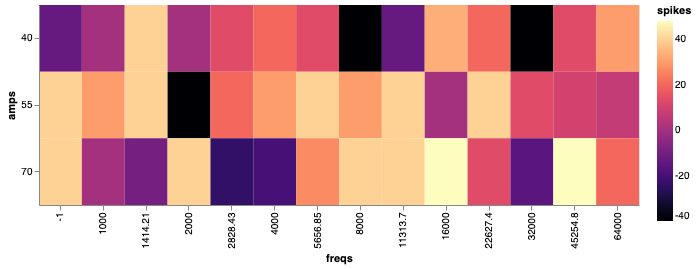

In [12]:
# with predigested data
plot_tuning_curve(df_tc, 1)

standard deviation not found, assuming this is raw spiking data and using summarize_tuning_curve


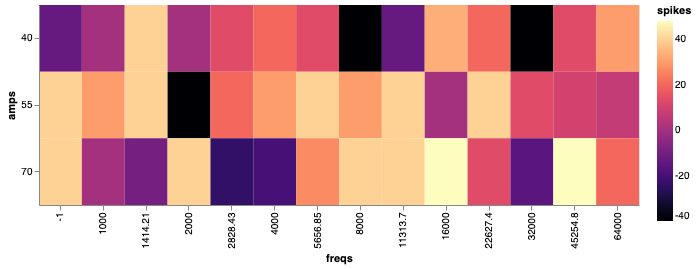

In [13]:
# with raw data
plot_tuning_curve(df, 1)

And again a little python magic to let us select our cells

In [14]:
interact(plot_tuning_curve,cell = sorted(df_tc['cell'].unique()), data=fixed(df_tc));

interactive(children=(Dropdown(description='cell', options=(1, 7), value=1), Output()), _dom_classes=('widget-…

## Thats all the analysis we have time for :(

you can see more example code from the last time i taught bootcamp here:
https://mybinder.org/v2/gh/wehr-lab/bootcamp_2018/master?filepath=bootcamp_2018.ipynb

# Beauty in Analysis

You probably didn't sign up to be a programmer, but surprise! all neuroscientists have to be programmers. You can think of your data analysis code as being a beautiful garden you can cultivate to get more comfortable, powerful, and easy to use over time by being conscious about best principles, or you can hate and fear it, struggle with it by constantly trying to do the minimum possible programming, and have it be just as frustrating every time you return to it.

## What **dont** we want our data to be like?

Time to write a paper! We go to analyze our data which is stored on **several different computers** in **different directory structures**, so we have to write new code to find and compile our data. We want to do something slightly different, but we have written our code in enormous script files and need to copy and paste them and make a brand new function. We never documented are functions so we've forgotten how they work. Our data is all in different formats so we have to spend time converting them all to a common format. Our scripts break because we are missing some function that we used to have but lost track of. etc. etc.


## Data Hygeine Practices

Your data is the foundation of your science. If your data isn't happy, then everything that comes afterwards becomes a horrible gnashing chore.

Some basic principles -- some of these are accepted best practice, some are my own thoughts, use the ones that work for you :)

* **Define what a "dataset" is** - what is the fundamental unit of your data? is it a single recording from a single cell? is it a single recording session with many cells? is it an experiment? Whatever it is define it and use that as the starting point for your data structure.
* **Data should be "Flat" and "Long"** 
    * Rather than having a nested data structure, your data should be flat -- while nested data structures may feel natural (eg. multiple runs of an experiment stored separately), you want to be able to "see" and operate on all your data at once. Let your code handle subsetting -- your goal should be to **never** have to manually sift through your data.
    * Your data should also be "long" -- where each *row* of the data represents a single observation (eg. a spike, a cell, etc.) and each *column* should represent a variable describing that observation. This involves making a decision about what an "observation" is, which is up to you. This is standard practice in data science (though there are obviously exceptions). 
* **Data should be *documented* and *annotated***
    * You should **document** the structure of your data. Write down and be explicit about the different variables you expect your data to have. As you write more and more code to analyze your data, minor differences in how you name your variables, whether certain variables are included in different data formats, etc. can propagate complexity and break everything. Writing a format specification is also necessary to share your data, so by doing it upfront and keeping it consistent across projects you save yourself lots of work downstream. An example from one of my recent papers: https://github.com/wehr-lab/SaundersWehr-JASA2019
    * You should **annotate** your data. Annotations, rather than being an external document someone can use to understand your data, are *embededded within the data itself* (I'm using annotation synonymously with metadata). This is useful for data publication (anyone can understand your data just using the data itself) but also for your own use -- you want to be able to find your data later! You can do this by using human-readable variable names, but you also can have explicit metadata: some file formats like [hdf5](https://support.hdfgroup.org/HDF5/whatishdf5.html) support metadata natively, but you can always create a metadata file using a structured language like [json](https://www.json.org/json-en.html), eg:
    
    ```json
    {
        'animal': 'animal_id',
        'date': '2020-01-01T15:35.125',
        'project': 'my_project_name'
    }
    
    ```
  
* **Stored data should be *analyzable* not *analyzed*** - store your data in such a way that doing your analyses on it is easy, but don't rely on storing and using the intermediate stages of your analysis unless you build an explicit "analysis pipeline" that can check for the presence of each of those stages. eg. you have raw spiking data you need to summarize into mean firing rates, and from that you compare population firing rates for many cells. If your population analysis code requires some intermediate data format and doesn't know how to generate it from your raw data, it will break if that intermediate format isn't present. This is not to say **never** store analyzed data -- indeed if your analysis takes a really long time you absolutely should save the analyzed form, but you should have an explicit analysis pathway that allows downstream functions to generate the intermediate forms if needed
* Consciously (write down the specification!) use a directory structure to keep everything and stick to it!
    * eg. you have different domains of your life, school, lab, personal projects, etc. 
    * within each of those you might have different, but common subtypes -- data, notes, documents, etc.
* **Store your data on a single server** or some other computer that persistently hosts your data. You want to be able to pull it from anywhere and not rely on carting flash drives from computer to computer. You don't want to have to look in multiple places. You want to configure your server to automatically back up your data -- make sure you have at least two copies, and having an offsite backup is highly recommended: every scientists knows someone whose lab burned down!



## Programming Practices

* Use Python - I will spare you my lenghty feelings about MATLAB as a language, i think it's sufficient to say it is a structurally flawed language that incentivizes bad programming practices that make it harder to learn general principles of programming. MATLAB is a dying language -- Python is ~20x more popular now and growing: https://pypl.github.io/PYPL.html . You should learn Python because it is already and will be increasingly the standard language in the field.
* Use version control - Don't write in local files in My Documents or on Dropbox. Version control makes your code public, keeps it localized for you, and lets you keep the same version of your code across computers. Code naturally branches and diverges, and version control is a structured way of keeping track of those versions-- you shouldn't be afraid to change a file because you know you have a saved version that you can revert to! Use git, Github is the most common git server, but there are others like BitBucket. Here is a decent introduction to git: https://learngitbranching.js.org/
* Write in functions and classes, not scripts - break your code down into small individual steps and write them as functions. Each function should do one thing and one thing only, and you should handle minor differences in function operation with arguments rather than by writing an additional function. Ideally, you should never repeat code. 
* code should be modular!
    * on a more macro level, organize the different parts of your code into hierarchical "modules," eg. group all your plotting functions together separately from loading, statistical analysis, etc. Modules help you avoid 
    * this also keeps you from losing your random files around your computer -- everything should ideally have only one obvious location.
* use explicit environments -- you dont want to rely on your computer being the same moment one day to the next, instead explicitly declare what packages/etc. are needed to run your code. in Python you use virtual environments https://docs.python.org/3/tutorial/venv.html
* document everything immediately -- Python has a utility for writing docstrings (some examples above) that let you document how a function works, what it does, and what arguments it expects. In the same way that you write an outline before writing a paper, start by outlining your code by writing "function stubs" that are just names and docstrings that describe the code you need and how it should work before you commit the time to actually writing the code. Don't wait to document later, you *will* forget how shit works.
* Read the docs & learn in a structured way -- there is a general tension between hacking something together and getting it to work quickly and spending time learning how to do things correctly. Especially early on it is worth giving yourself a structured background in programming. Python has wonderful official documentation: https://docs.python.org/3/tutorial/index.html . It is generally true that spending an hour reading documentation will save weeks of your life being frustrated and banging your head against the wall. 

One book that may be useful in thinking about good code practices is "A Philosophy of Software Design" https://school.hbh7.com/pdfs/RPI/%289781732102200%29%20John%20Ousterhout%20-%20A%20Philosophy%20of%20Software%20Design.epub

## General advice while learning programming

* Google often and always! search the text of error messages and keep searching. No matter how experienced a programmer is, they always constantly google everything.
* Keep asking for advice -- find people that are also learning to program or already know how, keep showing them your code and ask what they would do. Read blog posts where people describe what they do and why, etc.
